## PCA-BHC-SkogerboeDogFood
### Code is in R - https://github.com/IRkernel/IRkernel

This is what is called a "jupyter notebook" that can act as a report for data analysis query. It allows me to go right back into this document and modify code if we would like to revisit this later, which I imagine we will! I can also share it with other coders and they can run the same analysis on their computer, provided they have jupyter notebooks set up.

### Data Analysis
---

#### What to do with no peak area information
prcomp() the main PCA function we are using doesn't handle empty values well. It just ignores those variables in its model. There is some written about this, but it doesn't seem well supported. As analytical chemists however, we know exactly what is zero and what is not. It is the LOD.

So this little section could use some more thought, but to get it started I just did the following math.

We have:
~ 6 sec wide peaks (at base)

The mass spectrometer scans at 4.65 scans/sec

The TIC at baseline on a blank injection is at ~ 20000

Therefore, integration of the baseline would give us a value of... (in counts)

In [2]:
6*4.65*20000

[1] 558000

So I will fill in the data set with this value. It would probably be better if there was some noise added to this, but all that can be added later. I also just converted it to csv so the data import is a little more OS independent.

### 1. Load Data
The data set here is four different dog foods analyzed by SPME-GCMS. Each dog food was analyzed in triplicate.
We also picked peaks we were interested in off the chromatogram and took the area under the curve for those compounds for quantification. The data file is in "Dogfood Data no empties - Sheet1.csv"

Loading required package: rJava
Loading required package: xlsxjars


Ret.Time,Adult.1,Adult.2,Adult.3,Puppy.1,Puppy.2,Puppy.3,Chewy.1,Chewy.2,Chewy.3,Wild.1,Wild.2,Wild.3
4.500,558000,558000,558000,558000,558000,558000,113735754,86703782,80552407,27327962,26840217,25418880
5.748,86929795,87735857,85239926,106767945,104361560,104978220,558000,558000,558000,558000,558000,558000
8.280,416242816,411717253,419447337,77581748,76876413,77634029,558000,558000,558000,69593573,65493673,67890817
14.660,29900071,30870940,30666517,23087094,22624150,22964315,558000,558000,558000,52237029,42335733,47309095
17.500,157000114,162422764,168244971,205241780,200247542,204970387,94890040,83483720,79255958,375138252,372955077,381092892
19.300,45490442,46142947,44790862,59653252,58018100,63869993,15795670,13154202,12339052,134015238,130003936,126975058
20.800,109799573,117028102,117881707,215411094,213293582,218125734,26636310,23357089,22453344,210289507,201430201,206179147
22.290,14173522,14475711,16911178,16163520,14893254,15721003,7141868,5781812,5249081,83471627,79228920,80239010
23.464,60893355,65665854,67683230,29701918,27509817,28905323,29495331,23370769,23865100,37262340,33368515,34258783
26.550,167522111,185960710,208622712,113488742,122265717,120498510,22750862,17262730,16696468,51072314,36630912,36740414


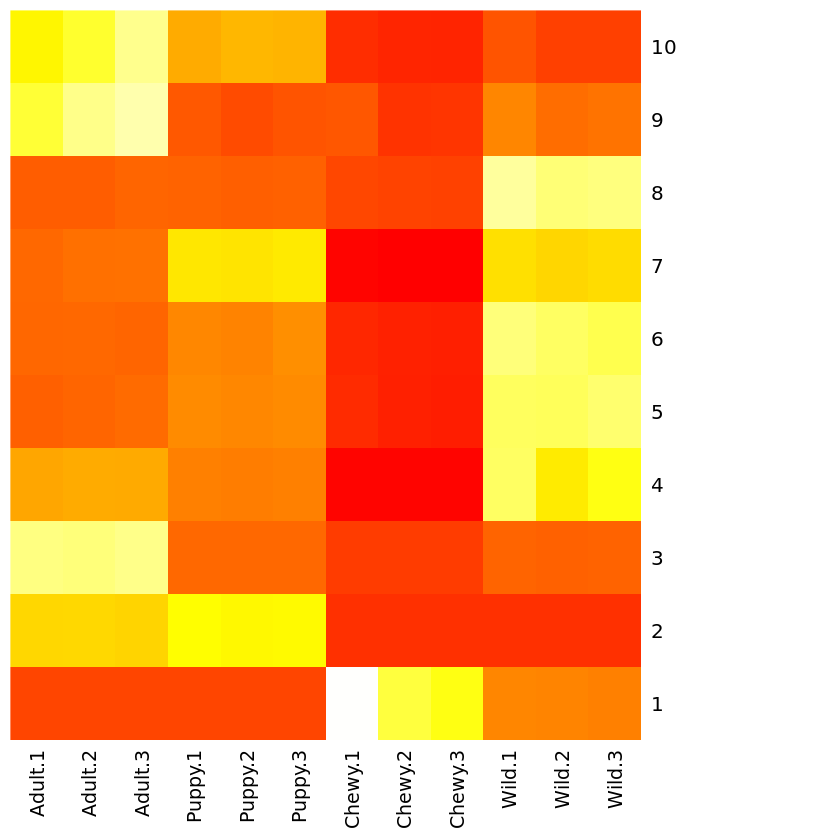

In [2]:
data = read.csv("./Dogfood Data no empties - Sheet1.csv")
data
heatmap(as.matrix(data[,2:13]),Rowv=NA, Colv=NA, col = heat.colors(256), scale="row", margins=c(5,10))

### 2. PCA

#### Lets prepare the data for PCA, we will use the log transformed data to run our PCA model
Raw peak area data as: peakareas.raw

Log transform peak areas as: peakareas.log

Retention time peak labels as: peakareas.peaks

The sample type/class is set as: peakareas.sampleclass

In [136]:
peakareas <- data
peakareas.raw <- peakareas[, 2:13]
peakareas.log <- log(peakareas[, 2:13])
peakareas.peaks <- peakareas[, 1]
peakareas.data <- t(peakareas.log)

colnames(peakareas.data) <- peakareas$Ret.Time
Class <- c("Adult","Adult","Adult","Puppy","Puppy","Puppy","Chewy","Chewy","Chewy","Wild","Wild","Wild")
peakareas.data <- data.frame(Class,peakareas.data)

#### Run PCA of log transformed data with mean centering and scaling. 

In [139]:
peakareas.pca <- prcomp(na.omit(peakareas.data[,2:11]), center = TRUE, scale. = FALSE)

Get some details about PCs

In [140]:
summary(peakareas.pca)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     4.5611 2.3645 0.67514 0.15824 0.06167 0.03805 0.02541
Proportion of Variance 0.7739 0.2080 0.01696 0.00093 0.00014 0.00005 0.00002
Cumulative Proportion  0.7739 0.9819 0.99883 0.99977 0.99991 0.99996 0.99999
                           PC8     PC9     PC10
Standard deviation     0.01411 0.01340 0.003525
Proportion of Variance 0.00001 0.00001 0.000000
Cumulative Proportion  0.99999 1.00000 1.000000

### How many PC's should we use?

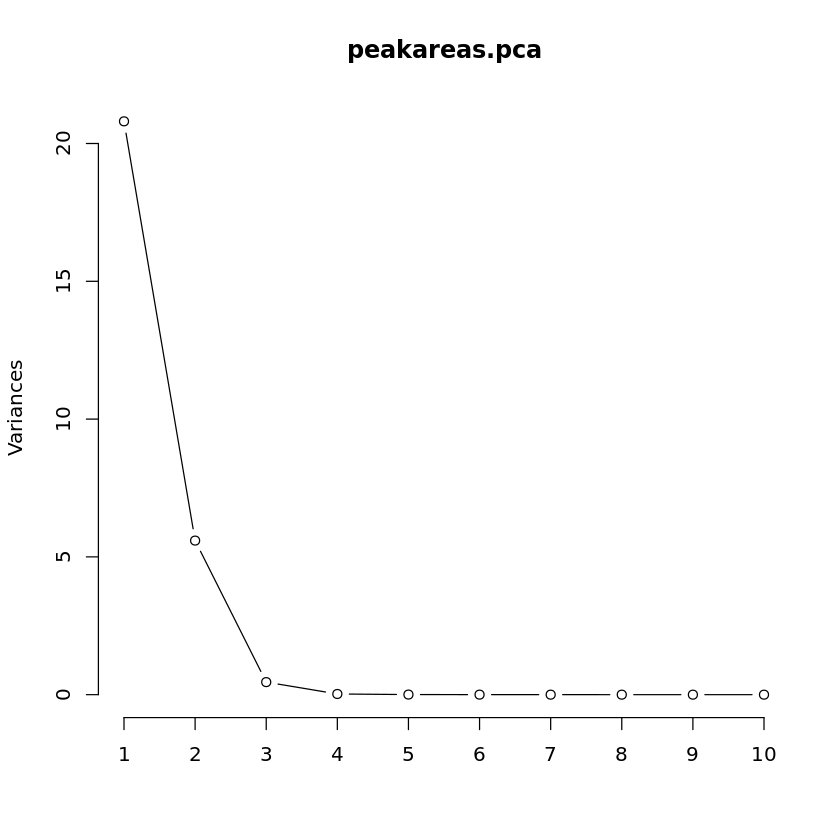

In [141]:
plot(peakareas.pca, type = "l")

### Looks like principle component 1 and 2 are separating with a small contributions from 3. The y-axis is a different measure than % variance explained, but related (on an absolute scale).

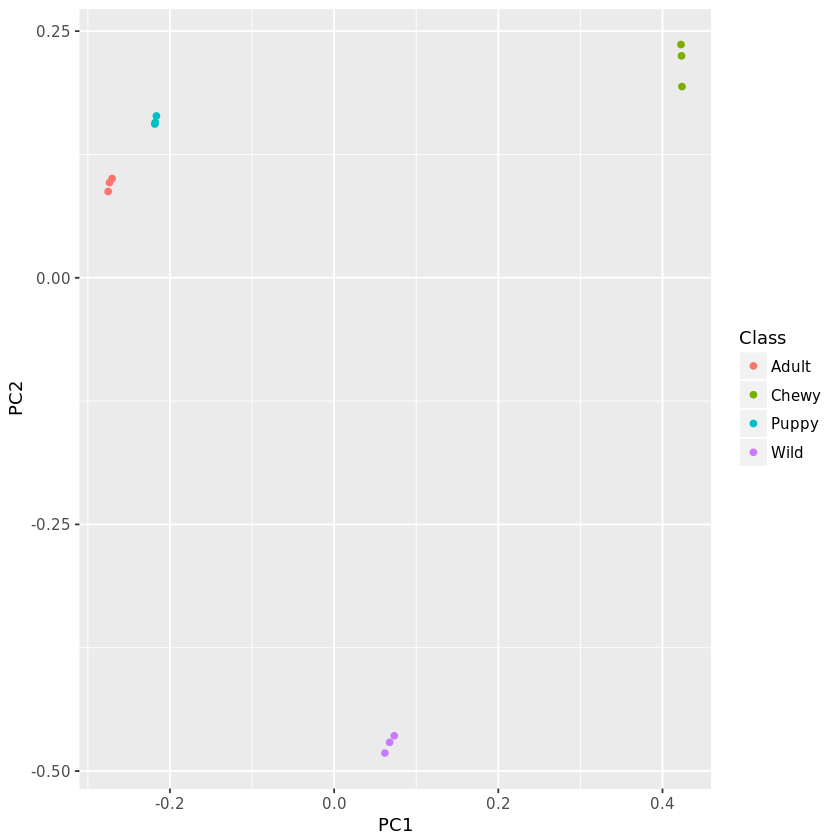

In [142]:
library(ggfortify)
#plot(peakareas.pca$x[,1],peakareas.pca$x[,2])
autoplot(peakareas.pca, data = peakareas.data, colour = "Class")

## Class separation! But what is doing the separating?

### 3. The rotation Matrix
The rotation matrix can tell you which original variables are important in each of the principal components. It is also called the **loadings** matrix.

For example, the first column of our rotation matrix shows contributions from PC1. A high value relative to the other coefficients means that the **first original variable** is important in the **first principal component**. 

Our first column in has a high positive value in the first row followed by many negative values, while the second columnhas a high positive value in the second row, surrounded by many negative values in all other rows. 

**This means that our first two peaks are doing most of the separating in this PCA model**

In general when looking at rotations (also called projections, loadings, etc) the closer values are together along a principle component axis (and the further away from other values) the more similar the original compound's peak areas are in the raw data.

#### Lets look at a Loadings Plot

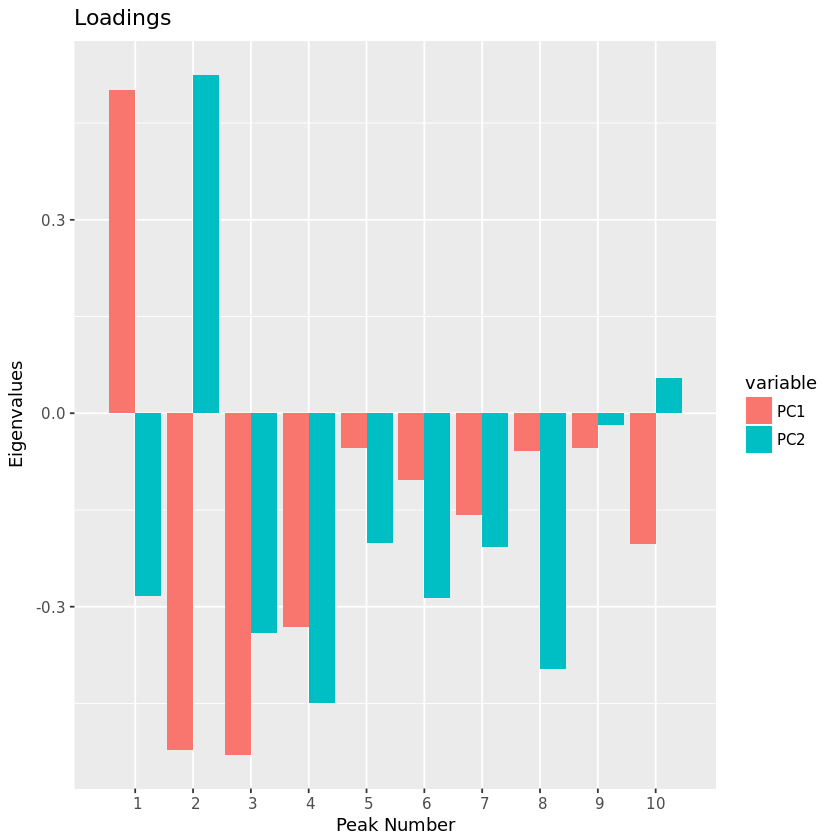

In [149]:
library("reshape2")
library("ggplot2")

rotations <- data.frame(peakareas.pca$rotation[,1],peakareas.pca$rotation[,2])
colnames(rotations) <- c("PC1","PC2")
Peak_Number = c(1:10)
rotations <- data.frame(Peak_Number,rotations)


df <- melt(rotations, id.vars='Peak_Number')
ggplot(df, aes(x=Peak_Number, y=value, fill=variable)) + 
    geom_bar(stat='identity', position='dodge') +
    scale_x_discrete(limit = c(1:10)) +
    labs(title = "Loadings", x = "Peak Number", y = "Eigenvalues")

---
## Beysian Hierarchical Clustering (BHC)
---
BHC can do the same as PCA, only better! It does not transform your data into somewhat arbitrary principle component axes that have no physical significance. Let's use some code from James Smith at the University of Leeds.

In [144]:
# biocLite("BHC", "gplots") # if you need to install
library(BHC) 
library(gplots)

#### Find Optimal Binning - (explanation goes here!)

In [145]:
FindOptimalBinning_J <-function (inputData, sampleNames, transposeData = FALSE, verbose = FALSE, robustFlag) 
{
  logEvidence.best <- -Inf
  percentiles.best <- c(0.33, 0.33, 0.33)
  for (i in 2:7) {
    v <- 5 * i
    percentiles.current <- 0.01 * c(v, 100 - 2 * v, v)
    discreteData <- DiscretiseData(inputData, percentiles = percentiles.current, verbose = verbose)
    if (transposeData) {
      discreteData <- t(discreteData)
      sampleNames <- vector("character", nrow(discreteData))
    }
    dendrogram <- bhc(discreteData, sampleNames, 3, robust=robustFlag, verbose = verbose, numThreads=4)
    logEvidence.bhc <- attr(dendrogram, "logEvidence")
    logEvidence.discrete <- attr(discreteData, "logEvidence")
    logEvidence.current <- logEvidence.bhc + logEvidence.discrete
    if (logEvidence.current >= logEvidence.best) {
      if (is.finite(logEvidence.current)) {
        logEvidence.best <- logEvidence.current
        percentiles.best <- percentiles.current
      }
    }
  }
  rangeArray <- 100 * percentiles.best[1] - 5 + 1:9
  for (i in rangeArray) {
    percentiles.current <- 0.01 * c(i, 100 - 2 * i, i)
    discreteData <- DiscretiseData(inputData, percentiles = percentiles.current, verbose = verbose)
    if (transposeData) {
      discreteData <- t(discreteData)
      sampleNames <- vector("character", nrow(discreteData))
    }
    dendrogram <- bhc(discreteData, sampleNames, 3, robust=robustFlag,verbose = verbose, numThreads=4)
    logEvidence.bhc <- attr(dendrogram, "logEvidence")
    logEvidence.discrete <- attr(discreteData, "logEvidence")
    logEvidence.current <- logEvidence.bhc + logEvidence.discrete
    if (logEvidence.current > logEvidence.best) {
      if (is.finite(logEvidence.current)) {
        logEvidence.best <- logEvidence.current
        percentiles.best <- percentiles.current
      }
    }
  }
  cat("", fill = TRUE)
  if (robustFlag==1){
    cat("OPTIMISED ML DISCRETISATION", fill = TRUE)
    cat("---------------------------", fill = TRUE)
  } else {
    cat("OPTIMISED DISCRETISATION", fill = TRUE)
    cat("------------------------", fill = TRUE)
  }
  cat("Percentiles:", percentiles.best, fill = TRUE)
  cat("LogEvidence:", logEvidence.best, fill = TRUE)
  invisible(percentiles.best)
}

### Starting parameters

In [147]:
robustFlag <- 1 ### BHC: Gaussian Model 0 or Mixture Likelihood Model 1  !!
X <- read.csv("Dogfood Data no empties - Sheet1.csv")
Xbhc <- t(X[,2:13])
X <- t(X)
head(X)
head(Xbhc)

Ret.Time,4.5,5.748000e+00,8.28,14.66,17.5,19.3,20.8,22.29,23.464,26.55
Adult.1,558000.0,8.692980e+07,416242816.00,29900071.00,157000114.0,45490442.0,109799573.0,14173522.00,60893355.000,167522111.00
Adult.2,558000.0,8.773586e+07,411717253.00,30870940.00,162422764.0,46142947.0,117028102.0,14475711.00,65665854.000,185960710.00
Adult.3,558000.0,8.523993e+07,419447337.00,30666517.00,168244971.0,44790862.0,117881707.0,16911178.00,67683230.000,208622712.00
Puppy.1,558000.0,1.067679e+08,77581748.00,23087094.00,205241780.0,59653252.0,215411094.0,16163520.00,29701918.000,113488742.00
Puppy.2,558000.0,1.043616e+08,76876413.00,22624150.00,200247542.0,58018100.0,213293582.0,14893254.00,27509817.000,122265717.00


Adult.1,558000,86929795,416242816,29900071,157000114,45490442,109799573,14173522,60893355,167522111
Adult.2,558000,87735857,411717253,30870940,162422764,46142947,117028102,14475711,65665854,185960710
Adult.3,558000,85239926,419447337,30666517,168244971,44790862,117881707,16911178,67683230,208622712
Puppy.1,558000,106767945,77581748,23087094,205241780,59653252,215411094,16163520,29701918,113488742
Puppy.2,558000,104361560,76876413,22624150,200247542,58018100,213293582,14893254,27509817,122265717
Puppy.3,558000,104978220,77634029,22964315,204970387,63869993,218125734,15721003,28905323,120498510


### Run BHC

In [148]:
col_names_for_BHC <- X[1,]
row_names_for_BHC <- row.names(X)

col_label <- "RetentionTime"
row_label <- "DogFood"

nDataItems <- nrow(X)
nFeatures <- ncol(X)

percentiles_a <- FindOptimalBinning_J(X,row_names_for_BHC,transposeData=TRUE,verbose=TRUE,robust=robustFlag)
discreteData_temp <- DiscretiseData(t(X), percentiles=percentiles_a) # apply to inv
discreteData_a <- t(discreteData_temp)
save(discreteData_a,file="discretizedData_a.Rda")
save(percentiles_a,file="percentiles_a.Rda")
rm(discreteData_temp)
hc_a <- bhc(discreteData_a, row_names_for_BHC, verbose=TRUE, robust=robustFlag, numThreads=4)
save(hc_a, file="hc_a.Rda")
txt_file_a<- paste0("hc_labels_",row_label,"_a.txt") 
WriteOutClusterLabels(hc_a, txt_file_a, verbose=TRUE)

percentiles_b <- FindOptimalBinning_J(t(X), col_names_for_BHC, transposeData=TRUE, verbose=TRUE,robustFlag)
discreteData_temp <- DiscretiseData(X, percentiles=percentiles_b) # apply to inv
discreteData_b <- t(discreteData_temp)
save(discreteData_b,file="discretizedData_b.Rda")
save(percentiles_b,file="percentiles_b.Rda")
rm(discreteData_temp)
hc_b <- bhc(discreteData_b, col_names_for_BHC, verbose=TRUE, robust=robustFlag, numThreads=4)
save(hc_b, file="hc_b.Rda")
txt_file_b <- paste0("hc_labels_",col_label,"_b.txt")
WriteOutClusterLabels(hc_b, txt_file_b, verbose=TRUE)


DATA DISCRETISATION
-------------------
Percentiles: 0.1 0.8 0.1 
We have the following parameters for the data array:
nGenes:       13
nExperiments: 10
***Please check that these are the right way round! (it affects the discretisation)***

Discretisation logEvidence: -2279.67539988932
(Need to add this to the model logEvidence)
-------------------
[1] Running Bayesian Hierarchical Clustering....
[1] "DataType: multinomial"
[1] Optimising global hyperparameter...
[1] 782.57541 -79.59682
[1] 1265.92459  -79.58016
[1] 1564.65082  -79.57501
[1] 1805.31590  -79.57211
[1] 1898.01298  -79.57119
[1] 1955.30292  -79.57066
[1] 1990.71006  -79.57035
[1] 2012.59287  -79.57017
[1] 2026.11719  -79.57006
[1] 2034.47568  -79.56999
[1] 2039.64151  -79.56994
[1] 2042.83417  -79.56992
[1] 2044.8073  -79.5699
[1] 2046.02683  -79.56989
[1] 2046.78051  -79.56989
[1] 2047.24632  -79.56988
[1] 2047.57968  -79.56988
[1] 2047.57968  -79.56988
[1] 2047.57968  -79.56988
[1] Hyperparameter: 2047.57967925599
[1] 


DATA DISCRETISATION
-------------------
Percentiles: 0.3 0.4 0.3 
We have the following parameters for the data array:
nGenes:       10
nExperiments: 13
***Please check that these are the right way round! (it affects the discretisation)***

Discretisation logEvidence: -2263.49826717978
(Need to add this to the model logEvidence)
-------------------
[1] Running Bayesian Hierarchical Clustering....
[1] "DataType: multinomial"
[1] Optimising global hyperparameter...
[1]    1.072949 -128.146703
[1]    1.427051 -128.700352
[1]    1.072949 -128.146703
[1]    1.072949 -128.146703
[1] Hyperparameter: 1.07294901687516
[1] Lower bound on overall LogEvidence: -1.2815e+02
[1] *******************
[1] ---CLUSTER 1 ---
[1] Ret.Time
[1] Chewy.1
[1] Chewy.2
[1] Chewy.3
[1] ---CLUSTER 2 ---
[1] Wild.1
[1] Wild.2
[1] Wild.3
[1] Adult.2
[1] Adult.1
[1] Adult.3
[1] Puppy.2
[1] Puppy.1
[1] Puppy.3

DATA DISCRETISATION
-------------------
Percentiles: 0.1 0.8 0.1 
We have the following parameters for the da


DATA DISCRETISATION
-------------------
Percentiles: 0.3 0.4 0.3 
We have the following parameters for the data array:
nGenes:       13
nExperiments: 10
***Please check that these are the right way round! (it affects the discretisation)***

Discretisation logEvidence: -2173.99919910067
(Need to add this to the model logEvidence)
-------------------
[1] Running Bayesian Hierarchical Clustering....
[1] "DataType: multinomial"
[1] Optimising global hyperparameter...
[1]  782.5754 -141.7602
[1] 1265.9246 -141.7075
[1] 1564.6508 -141.6911
[1] 1808.3786 -141.6818
[1] 1715.283 -141.685
[1] 1899.9058 -141.6789
[1] 1956.4728 -141.6772
[1] 1991.4331 -141.6763
[1] 2013.0397 -141.6757
[1] 2026.3934 -141.6753
[1] 2034.6464 -141.6751
[1] 2039.747 -141.675
[1] 2042.8994 -141.6749
[1] 2044.8476 -141.6748
[1] 2046.0517 -141.6748
[1] 2046.7959 -141.6748
[1] 2047.2558 -141.6748
[1] 2047.5892 -141.6748
[1] 2047.5892 -141.6748
[1] 2047.5892 -141.6748
[1] Hyperparameter: 2047.5891908255
[1] Lower bound on 

### Now I need to make some pretty plots and explain what is going on. Although it looks like my model might not be doing what I need it to...